# Species Distribution Model (SDM)

#### Intro
As marine ecosystems undergo global climate change, there is an increasing need to incorporate potential shifts in the distribution of marine taxa into management plans

We propose that the best models—those that effectively describe or predict marine animal distribution patterns at a desired temporal scale without utilizing unnecessarily high-resolution data—are obtained when the temporal characteristics of the animals’ distribution and environmental data sufficiently match the scale of the ecological question and the variability of the ecosystem

#### Data & Variability
*Instantaneous covariates* represent the state of the environment in close proximity to the animal (i.e., within its direct perceptual range) at the moment it was observed.

*Contemporaneous covariates* represent the state of the environment in a time window (typically days to months)

**This dataset is identified as:**
*Climatological datasets* divide the calendar year into shorter time slices such as days, weeks, months or seasons, and for each slice, apply a summary statistic (e.g., mean, variance, frequency or probability) to many (often at least 10) years of observations made during that slice to estimate the long-term state

Are contemporaneous covariates are necessary or climatological covariates are sufficient to model these associations?

we acknowledge that current sampling abilities and requirements lead to imperfect models and potentially biased predictions and practical recommendations are critically needed for ecologists and managers.

SDMs developed from climatological covariates are relevant for static management and used to predict important species habitats with a high potential for delineation of marine-protected areas and implementation of mitigation measures

#### Scale of the ecological question
Macroscale (Figure 4)
animal distribution: Fisheries, historical catches, species coverage
enviro data: sum of in situ databases, climatological oceanographic covariates
temporal resolution: climatological 

#### Outcome
Torres et al. (2013) modelled the seasonal distribution of southern right whales (Eubalaena australis) by comparing the predicted habitat suitability maps with maps of shipping traffic to identify areas of increased risk of collision where mitigation measures could be implemented.

[Source](https://onlinelibrary.wiley.com/doi/full/10.1111/ddi.12609)

#### Methods and Techniques (250 words max)
Process-based modeling
Global change includes changes in climate, habitat connectivity and nutrient dynamics at various spatial and temporal scales.

the model should allow an exploration of how these changes affect outcomes. 

Changing the scale of a process can alter the relative importance of key drivers, or disrupt the process altogether.

Complex simulation models can be process-based, but a highly dimensional model will be difficult to analyze. As the number of estimated parameters increases, the size of the parameter space (i.e., the number of possible combinations of parameter values) increase

#### Social Impact
The protection and restoration of coastal wetlands can be more cost effective than barrier construction as a means to reduce storm damage (Halpern et al. 2007, Costanza et al. 2008, although see Francis et al. 2011).

[Source](https://esajournals.onlinelibrary.wiley.com/doi/10.1890/ES12-00178.1)

[Source](https://daniel-furman.github.io/Python-species-distribution-modeling/)

#### Data (250 words max)
Special attention should be put on any scaling mismatches, meaning cases where the spatial (or temporal) grain or extent doe not match between biodiversity and environmental data or within environmental data. In these cases, we need to make decisions about adequate **upscaling and downscaling strategies.**

**absence data** are rarely available. In such cases, adequate background data or pseudo-absence data needs to be selected.

for later model assessment we may wish to partition the data into training data and validation data (Hastie, Tibshirani, and Friedman 2009)

## Import Libraries

In [211]:
#Libraries
import pandas as pd
import numpy as np
import datetime
from scipy.stats.stats import pearsonr

#Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modeling & Metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

# Data Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/7l/441dnk_52sgfldpwf_5_7dmr0000gn/T/ipykernel_95009/444782669.py:5: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


## Load the Dataset

In [212]:
# Species data
df = pd.read_csv('all_species.csv')

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Columns: 158 entries, Datetime to Abundance (ind/m2)
dtypes: float64(153), object(5)
memory usage: 2.3+ MB


In [214]:
df.head()

,Datetime,Tide,Weather Condition,Water temperature (ºC),Zone,Supratidal/Middle Intertidal,Substrate,Chthamalus sp.,Balanus perforatus,Patella sp.,...,Callionymus lira (peixe-pau lira),Oncidiella celtica,Doriopsilla areolata (nudibrânquio),Scorpaena sp. (Rascasso),Lipophrys pholis (ad.),Diplodus cervinus,Gobiusculus flavescens,Sessile Coverage,Total Mobile Species,Abundance (ind/m2)
0,11/28/2011 10:10:00,0.6,Clear sky,16.0,D,Medium,Puddle,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.45,4.0,0.05
1,11/28/2011 10:25:00,0.6,Clear sky,16.0,D,Medium,Rock,8.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.10,2.0,0.10
2,11/28/2011 10:40:00,0.6,Clear sky,16.0,D,Medium,Rock,25.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.20,1.0,0.00
3,11/28/2011 11:00:00,0.6,Clear sky,16.0,E,Medium,Rock,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2.0,0.20
4,11/28/2011 11:15:00,0.6,Clear sky,16.0,E,Medium,Rock,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.25,0.0,0.00


In [215]:
df[['Tide', 'Water temperature (ºC)', 'Sessile Coverage', 'Total Mobile Species','Abundance (ind/m2)']].describe()

,Tide,Water temperature (ºC),Sessile Coverage,Total Mobile Species,Abundance (ind/m2)
count,1949.000000,1949.000000,1949.000000,1945.000000,1949.000000
mean,0.728086,16.833299,52.866239,3.900771,0.210236
std,0.180290,2.255414,34.441960,12.853757,0.646289
min,0.300000,11.000000,0.000000,0.000000,0.000000
25%,0.600000,15.000000,21.050000,0.000000,0.000000
50%,0.700000,17.000000,57.000000,0.000000,0.000000
75%,0.900000,19.000000,85.100000,3.000000,0.150000
max,1.400000,22.000000,123.500000,254.000000,12.700000


**Initial Observations**
- `Tide` has a nearly equal mean and median with a majority of values spread within 2 (TODO: How was tide measured?), indicating a possible normal distribution.
- `Water temperature (ºC)` may have a similar distribution to `Tide`. Are observed min and max values related for these features due to an event?
- `Sessile Coverage` may need to be plotted to confirm if the distribution is normal. Is there a time factor, like seasonality?
- `Total Mobile Species` and related field `Abundance(ind/m2)` has a relatively large range of sample values. Double check that thes values appear to be correlated.

**Note**: This evaluation is not only to determine the shape of the distribution, as all numeric columns are transformed by removing the mean value of each feature, then scaling it using SciKit Learn's Preprocessing library.


## Data Preprocessing

### Building a Pipeline

In [216]:
numeric_features = ['Tide', 'Water temperature (ºC)', 'Sessile Coverage']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())]
)

categorical_features = ['Weather Condition']
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### Train/Test split

In [217]:
# Define X and y
X = df[['Datetime'] + numeric_features + categorical_features].sort_values(by='Datetime')
y = df['Abundance (ind/m2)']

In [218]:
X["Weather Condition"].value_counts()

Clear sky          1385
Cloudy              345
Sunny                94
Rain                 83
Fairly Cloudy        33
Sunny and Windy       9
Name: Weather Condition, dtype: int64

Since only 9 Sunny and Windy collapse with Sunny

In [219]:
X["Weather Condition"].replace(to_replace="Sunny and Windy", value="Sunny", inplace=True)

In [220]:
X["Weather Condition"].value_counts()

Clear sky        1385
Cloudy            345
Sunny             103
Rain               83
Fairly Cloudy      33
Name: Weather Condition, dtype: int64

In [221]:
# Perform train-test split without shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1559, 5) (1559,)
(390, 5) (390,)


## Model Selection

#### Linear Regressor

In [222]:
# Create the pipeline with preprocessor and linear regressor
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear', LinearRegression())
])

# Fit the pipeline on the data
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tide',
                                                   'Water temperature (ºC)',
                                                   'Sessile Coverage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Weather Condition'])])),
                ('linear', LinearRegression())])

#### Random Forest Regressor

In [223]:
# Create the pipeline with preprocessor and random forest regressor
forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('forest', RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18))
])

# Fit the pipeline on the data
forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tide',
                                                   'Water temperature (ºC)',
                                                   'Sessile Coverage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Weather Condition'])])),
                ('forest',
                 RandomForestRegressor(max_depth=5, max_features='sqrt',
                                       n_estimators=300, random_state=18))])

### Model Evaluation
Evaluate the trained models using appropriate metrics such as mean squared error (MSE) and mean absolute error (MAE).  Compare the performance of different models.

In [224]:
linear_y_preds = linear_pipeline.predict(X_test)
mean_squared_error(y_test, linear_y_preds)

0.07897270580635188

In [225]:
# Predict and score
forest_y_preds = forest_pipeline.predict(X_test)
mse = mean_squared_error(y_test, forest_y_preds)
mse

0.0844898535643204

In [226]:
rmse = mse**0.5
rmse

0.290671384151107

/var/folders/7l/441dnk_52sgfldpwf_5_7dmr0000gn/T/ipykernel_95009/2690706151.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
/var/folders/7l/441dnk_52sgfldpwf_5_7dmr0000gn/T/ipykernel_95009/2690706151.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

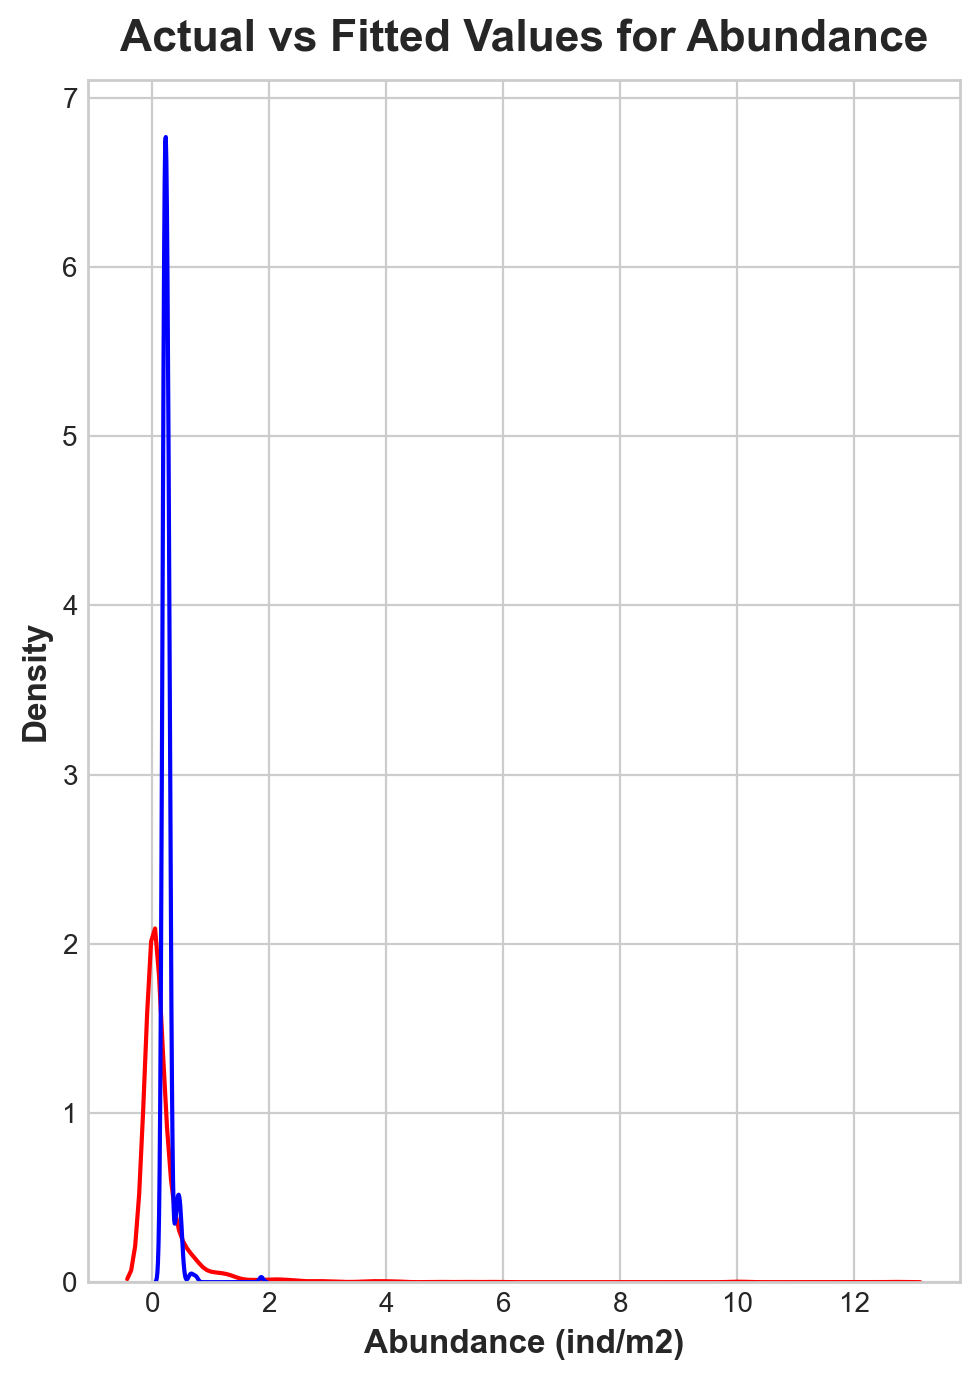

In [227]:
# Plot difference between the actual and the predicted values
plt.figure(figsize=(5, 7))


ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(forest_y_preds, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values for Abundance')


plt.show();

### Feature Importances
Determine features that influence the abundance of mobile species.

In [228]:
import eli5

In [229]:
# Extract encoded feature names and append them to the known list of numerical features
onehot_columns = list(forest_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

In [230]:
target_names = y_test.unique().astype(str)

In [231]:
eli5.explain_weights(forest_pipeline.named_steps['forest'], top=3, feature_names=numeric_features_list)

Explanation(estimator="RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,\n                      random_state=18)", description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='Sessile Coverage', weight=0.5147921968530507, std=0.22723326961848367, value=None), FeatureWeight(feature='Tide', weight=0.2483060751866285, std=0.1657843072638739, value=None), FeatureWeight(feature='Water temperature (ºC)', weight=0.18808837184508906, std=0.1639532147137511, value=None)], remaining=5), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

[Source](https://towardsdatascience.com/extracting-feature-importances-from-scikit-learn-pipelines-18c79b4ae09a)

### Test Model

### Conclusion
Summarize your findings, discuss any insights gained from the analysis, and suggest future steps for improvement if applicable.